In [1]:
## import module
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
## model input dimension
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)  # input image dimension

z_dim = 100  # 생성자의 입력으로 사용될 잡음 벡터의 크기

In [3]:
## 생성자 (generator)
def build_generator(img_shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=z_dim))  # 완전 연결층
    model.add(LeakyReLU(alpha=0.01))  # 활성화 함수
    model.add(Dense(28 * 28 * 1, activation='tanh'))  # 출력층
    model.add(Reshape(img_shape))  # 생성자 출력을 이미지 차원으로 변경
    return model

In [4]:
## 판별자 (discriminator)
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))  # 입력 이미지를 일렬로 펼치기
    model.add(Dense(128))  # 완전 연결층
    model.add(LeakyReLU(alpha=0.01))  # LeakyReLU 활성화 함수
    model.add(Dense(1, activation='sigmoid'))  # sigmoid 활성화 함수를 사용한 출력층
    return model

In [5]:
## GAN 모델 만들기와 컴파일
def build_gan(generator, discriminator):

    model = Sequential()

    model.add(generator)  # 생성자 + 판별자 모델 연결
    model.add(discriminator)

    return model

discriminator = build_discriminator(img_shape)  # 판별자 모델 만들고 컴파일
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)  # 생성자 모델 만들기

discriminator.trainable = False  # 생성자 훈련할 때 판별자 파라미터 동결

gan = build_gan(generator, discriminator)  
# 생성자를 훈련하기 위해 동결한 판별자로 GAN 모델 만들고 컴파일
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [6]:
## 생성된 이미지 출력
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡읍 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z, verbose=0)  # 랜덤한 잡음에서 이미지 생성

    gen_imgs = 0.5 * gen_imgs + 0.5  # 이미지 픽셀 값을 [0, 1] 범위로 스케일 조정

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [7]:
## GAN 훈련

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data()  # MNIST 데이터셋 로드

    X_train = X_train / 127.5 - 1.0  # [0, 255] 흑백 픽셀 값을
    X_train = np.expand_dims(X_train, axis=3)  # [-1, 1]사이로 스케일 조정

    real = np.ones((batch_size, 1))  # 진짜 이미지 레이블: 모두 1

    fake = np.zeros((batch_size, 1))  # 가짜 이미지 레이블 : 모두 0

    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], batch_size)  # 진짜 이미지에서 랜덤 배치 가져오기
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))  # 가짜 이미지 배치 생성

        gen_imgs = generator.predict(z, verbose=0)

        g_loss = gan.train_on_batch(z, real)  # 생성자 훈련

        z = np.random.normal(0, 1, (batch_size, 100))  # 가짜 이미지 배치 생성
        d_loss_real = discriminator.train_on_batch(imgs, real)  # 판별자 훈련
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)



        if (iteration + 1) % sample_interval == 0:
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))  
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print(f'{iteration + 1} [D: 손실: {d_loss}, 정확도: {100.0 * accuracy:.2f}%] [G 손실: {g_loss}]')
            
            sample_images(generator)  # 생성된 이미지 샘플 출력


1000 [D: 손실: 0.13211650028824806, 정확도: 94.14%] [G 손실: 3.146496295928955]
2000 [D: 손실: 0.052604762837290764, 정확도: 99.61%] [G 손실: 3.3966970443725586]
3000 [D: 손실: 0.08635731972754002, 정확도: 96.88%] [G 손실: 4.569447040557861]
4000 [D: 손실: 0.15763041377067566, 정확도: 92.19%] [G 손실: 4.285304546356201]
5000 [D: 손실: 0.12731517851352692, 정확도: 94.92%] [G 손실: 4.9970011711120605]
6000 [D: 손실: 0.24075257033109665, 정확도: 90.23%] [G 손실: 3.4850497245788574]
7000 [D: 손실: 0.13430923223495483, 정확도: 94.14%] [G 손실: 4.156820774078369]
8000 [D: 손실: 0.31239913403987885, 정확도: 89.06%] [G 손실: 3.7473411560058594]
9000 [D: 손실: 0.3238976001739502, 정확도: 86.72%] [G 손실: 3.222853660583496]
10000 [D: 손실: 0.355383962392807, 정확도: 85.94%] [G 손실: 3.5036869049072266]
11000 [D: 손실: 0.29707982391119003, 정확도: 87.89%] [G 손실: 3.0440874099731445]
12000 [D: 손실: 0.271876685321331, 정확도: 88.67%] [G 손실: 3.508589744567871]
13000 [D: 손실: 0.3226233571767807, 정확도: 86.72%] [G 손실: 2.588629961013794]
14000 [D: 손실: 0.4327111393213272, 정확도: 81.25%]

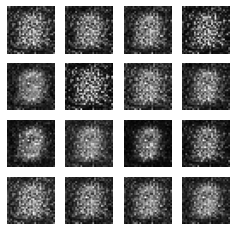

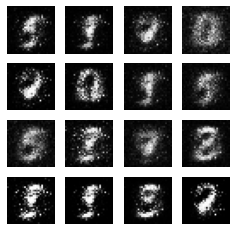

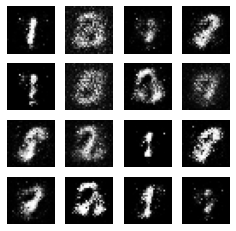

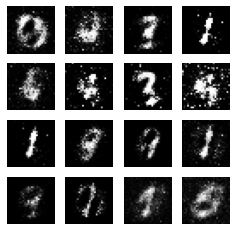

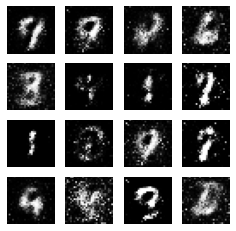

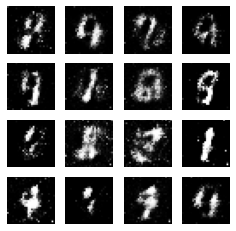

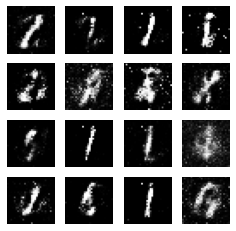

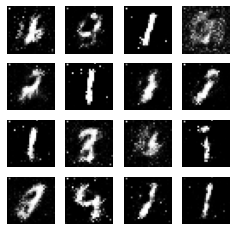

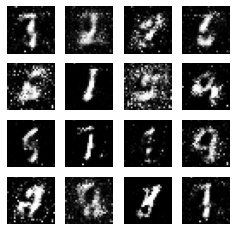

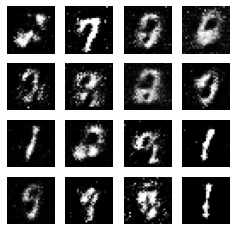

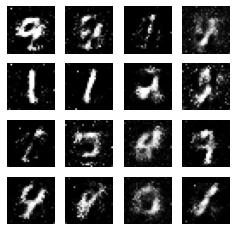

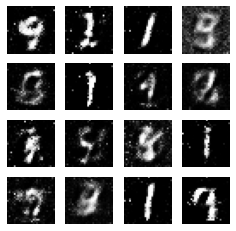

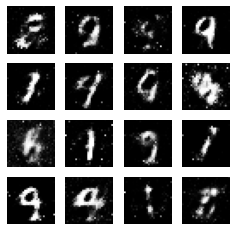

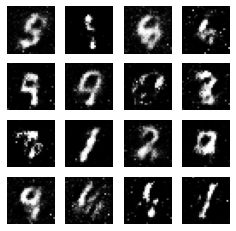

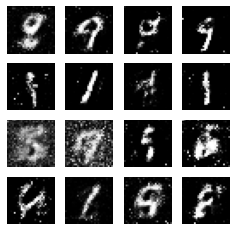

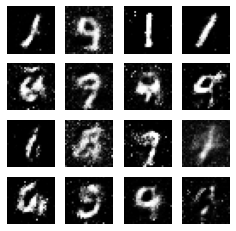

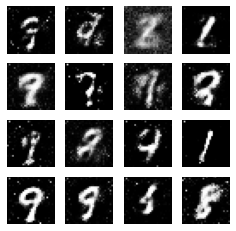

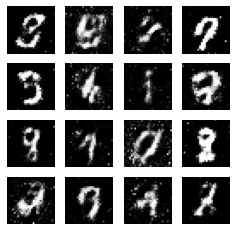

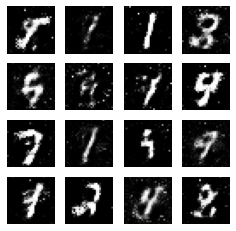

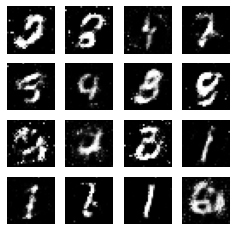

In [8]:
## 모델 실행
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)